### 1D Heat equation
Assume a thin rod of length $L$, we would like to model the heat (thermal energy) along it. <br>
Let $u(x,t)$ be the temperature in the rod at position $x$ and time $t$. <br>
Under ideal conditions: perfect insulation, no external heat sources, uniform rod material; the temperature is given by the following PDE (partial derivative equation): 
$$\frac{\partial u(t,x)}{\partial t} = a^2 \frac{\partial^2 u(t,x)}{\partial x^2}$$<br>
$$u(0,t) = u(L,t) = 0 \textrm{, which are the Dirichlet boundary conditions}$$ <br>
$$u(x,0) = f(x) \textrm{, which is the initial condition}$$<br>
$$x \in [0,L], \textrm{ }t > 0$$

We will take the following initial condition: $f(x) = 2sin\left( \frac{\pi x}{L} \right) - sin\left( \frac{3 \pi x }{L} \right) $
***
FYI here is the analytical solution.<br><br>
$u(x,t)$ can be written as: $$u(x,t) = v(x)w(t)$$
The PDE becomes:
$$v(x)w'(t) = a^2v''(x)w(t)$$
which can be written as:
$$ \frac{v''(x)}{v(x)} = \frac{w'(t)}{a^2 w(t)} = - \lambda $$ <br>
where $\lambda$ is a constant. We get two subproblems: <br><br>
$$v''(x) + \lambda v(x) = 0, v(0)=v(L)=0$$
and $$w'(t) + a^2\lambda w(t) = 0$$ <br> 
The first sub-problem is a *Sturm-Liouville problem*, where the solution is given by <br> <br>
$$v(x) = \alpha _n sin\left( \frac{n \pi}{L}x \right), \lambda = \left( \frac{n \pi}{L} \right) ^2, \alpha _n \textrm{  an arbitrary constant}$$ <br>
The solution of the second sub-problem can be solved by integration : 
$$\frac{dw}{w} = -a^2 \lambda dt$$
$$ln(w) = -a^2 \lambda t$$
$$w(t) = exp\left( -a^2 \left( \frac{n \pi}{L} \right)^2 t \right)$$ <br>
Without the initial condition, the general solution is 
$$u(x,t) = \sum _ {n=1}^{\infty} \alpha _n sin\left( \frac{n \pi}{L}x \right) \: exp\left( -a^2 \left( \frac{n \pi}{L}\right) ^2t \right)$$
with $\alpha _n$ arbitrary constants. <br><br>
Finally, let's add the initial condition: 
$$u(x,0) = \sum _ {n=1}^{\infty} \alpha _n sin\left( \frac{n \pi}{L}x \right) = f(x) =  2sin\left( \frac{\pi x}{L} \right) - sin\left( \frac{3 \pi x }{L} \right)$$ <br>
To the satisfy the inital condition, the constants $\alpha _n$ should be the Fourier coefficients of the sine series:
$$\alpha _n = \frac{2}{L}\int_{0}^{y} f(y)sin \left(\frac{n \pi}{L}   y\right) \,dy $$ <br>
From our inital solution: $\alpha_1 = 2$ and $\alpha_3 = -1$ <br><br>
$$u(x,t) = 2sin\left( \frac{\pi}{L}x \right)exp\left(-a^2 \left( \frac{\pi}{L} \right)^2t \right) -sin\left( \frac{3 \pi}{L}x \right)exp\left(-a^2 \left( \frac{3 \pi}{L} \right)^2t \right)$$

# Inference
$N_u$ points for the initial and boundaries conditions:
$$u(0,t) = u(L,t) = 0 \textrm{, which are the Dirichlet boundary conditions}$$ <br>
$$u(x,0) = f(x) \textrm{, which is the initial condition}$$<br>
$$x \in [0,L], \textrm{ }t > 0$$
$N_f$ collocations points for the PDE:
$$\frac{\partial u(t,x)}{\partial t} = a^2 \frac{\partial^2 u(t,x)}{\partial x^2}$$<br>
$$x \in [0,L], \textrm{ }t > 0$$
<div>
<img src="img/5.PNG" width="500"/>
</div>

### DNN

In [1]:
import torch
from torch import nn 
from collections import OrderedDict
torch.manual_seed(0)

class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(len(layers) - 2): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (len(layers) - 2), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)

        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

### PINN

In [5]:
import torch.optim as optim

class PINN():
    def __init__(self, layers, a, xt_train, xt_f, u_train, tol=1e-5, hs=50, verbose=True): 
        
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.verbose = verbose
        if self.verbose:
            print(f"device used: {self.device}")
            print(f"xt_train shape: {xt_train.shape}")
            print(f"xt_f shape: {xt_f.shape}")
            print(f"u_train shape: {u_train.shape}")
        
        self.net = DNN(layers).to(self.device)
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
    
        self.x_tr = torch.tensor(xt_train[:, 0:1], requires_grad=True).float().to(self.device) 
        self.t_tr = torch.tensor(xt_train[:, 1:2], requires_grad=True).float().to(self.device) 
        self.x_f = torch.tensor(xt_f[:, 0:1], requires_grad=True).float().to(self.device) 
        self.t_f = torch.tensor(xt_f[:, 1:2], requires_grad=True).float().to(self.device) 
        self.u_tr = torch.tensor(u_train).float().to(self.device)
        self.a = a 
        
        self.optimizer = torch.optim.LBFGS(
            self.net.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=hs,
            tolerance_grad=tol, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"    
        )

        self.iter = 1
        
    def net_u(self, x, t): #get u(x,t) for a pair (x,t); a forward pass through the PINN
        u = self.net(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t): #get f = du/dt - a^2 * d^2u / dx^2 
        u = self.net_u(x, t)
        u_t = torch.autograd.grad( #first partial derivative with respect to t
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad( #first partial derivative with respect to x
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad( #second partial derivative with respect to x
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        f = u_t - self.a**2 * u_xx #the computed PDE, we want to be a close as possible to 0
        return f

    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.x_tr, self.t_tr) #100, 1; all the ic/bc pairs were feeded through the PINN
        f_pred = self.net_f(self.x_f, self.t_f) #10456, 1; all the collocations points were feeded through the PINN
        
        loss_u = torch.mean((self.u_tr - u_pred) ** 2) #MSE loss on the ic/bc pairs, MSE loss on trainset, classic NN
        loss_f = torch.mean(f_pred ** 2) #MSE loss on the collocations pairs, regularization term
        
        loss = loss_u + loss_f #classic loss + regularization loss (enforce the PDE structure) => PINN loss
        
        loss.backward() #backpropagation
        
        self.iter += 1
        if self.verbose:
            if self.iter % 100 == 0:
                print(
                    'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u.item(), loss_f.item())
                )
        return loss
    
    def train(self):
        self.net.train()
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)

            
    def predict(self, xt):
        x = torch.tensor(xt[:, 0:1], requires_grad=True).float().to(self.device) #get x from pair
        t = torch.tensor(xt[:, 1:2], requires_grad=True).float().to(self.device) #get t from pair

        self.net.eval()
        
        u = self.net_u(x, t) 
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

### Data generation

In [60]:
import numpy as np
from pyDOE import lhs

a = 0.5
L = 2
tmax = 1

Nu = 200
Nf = 10000

def initial_condition(x, L):
    return 2 * np.sin(np.pi * x / L) - np.sin(3 * np.pi * x / L)

def exact_solution(x, t, a, L):
    return 2 * np.sin(np.pi * x / L) * np.exp(-a**2 * (np.pi / L)**2 * t) - np.sin(3 * np.pi * x / L) * np.exp(-a**2 * (3 * np.pi / L)**2 * t)

t = np.arange(0, tmax + 1/Nu, tmax/Nu).reshape(-1,1) #(Nu+1, 1)
x = np.arange(0, L + 1/Nu, L/Nu).reshape(-1,1) #(Nu+1, 1)
xt = np.hstack([x, t])
x_fine = np.arange(0, L + 1/Nu, 1/Nu).reshape(-1,1) #(2*Nu+1, 1)
t_fine = np.arange(0, tmax + 1/Nu, 1/Nu).reshape(-1,1) #(2*Nu+1, 1)
X, T = np.meshgrid(x_fine, t_fine)
xt_sol = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_sol = exact_solution(xt_sol[:,0:1], xt_sol[:,1:2], a, L)
U_sol = u_sol.reshape(X.shape)

xt_bc1 = np.hstack([np.zeros(xt[:,0:1].shape), xt[:,1:2]])
xt_bc2 = np.hstack([L* np.ones(xt[:,0:1].shape), xt[:,1:2]])
xt_ic = np.hstack([x_fine, np.zeros(x_fine.shape)])

u_bc1 = np.zeros(xt_bc1[:,0:1].shape)
u_bc2 = np.zeros(xt_bc1[:,0:1].shape)
u_ic = initial_condition(x_fine, L)

xt_tr = np.vstack([xt_bc1, xt_bc2, xt_ic])
u_tr = np.vstack([u_bc1, u_bc2, u_ic])

xt_f = xt.min(0) + (xt.max(0) - xt.min(0)) * lhs(2, Nf)
xt_f = np.vstack([xt_f, xt_tr])

idx = np.random.choice(xt_tr.shape[0], Nu, replace=False)
xt_train = xt_tr[idx, :]
u_train = u_tr[idx, :]

### Create and train PINN

In [72]:
%%time

nb_nodes = 20
nb_hidden_layers = 9
layers = np.hstack([np.array([2]),np.full(nb_hidden_layers, nb_nodes),np.array([1])])

model = PINN(layers, a, xt_train, xt_f, u_train, tol=1e-5, hs=50)

model.train()

device used: cuda:0
xt_train shape: (200, 2)
xt_f shape: (10803, 2)
u_train shape: (200, 1)
Iter 100, Loss: 2.83742e-02, Loss_u: 1.77948e-02, Loss_f: 1.05794e-02
Iter 200, Loss: 8.48438e-03, Loss_u: 5.85483e-03, Loss_f: 2.62954e-03
Iter 300, Loss: 4.29969e-03, Loss_u: 9.41206e-04, Loss_f: 3.35849e-03
Iter 400, Loss: 9.59475e-04, Loss_u: 3.05110e-04, Loss_f: 6.54366e-04
Iter 500, Loss: 5.09709e-04, Loss_u: 1.05405e-04, Loss_f: 4.04304e-04
Iter 600, Loss: 3.21363e-04, Loss_u: 3.18641e-05, Loss_f: 2.89499e-04
Iter 700, Loss: 1.78808e-04, Loss_u: 2.14409e-05, Loss_f: 1.57367e-04
Iter 800, Loss: 1.35444e-04, Loss_u: 1.21805e-05, Loss_f: 1.23264e-04
Iter 900, Loss: 8.41923e-05, Loss_u: 4.58943e-06, Loss_f: 7.96029e-05
Iter 1000, Loss: 5.80914e-05, Loss_u: 6.80704e-06, Loss_f: 5.12844e-05
Iter 1100, Loss: 3.94412e-05, Loss_u: 7.84487e-06, Loss_f: 3.15964e-05
Iter 1200, Loss: 2.91927e-05, Loss_u: 5.35686e-06, Loss_f: 2.38358e-05
Iter 1300, Loss: 2.27601e-05, Loss_u: 3.75349e-06, Loss_f: 1.9006

### Evaluate

In [73]:
def l2_norm(pred, true):
    return np.linalg.norm(true - pred,2)/np.linalg.norm(true, 2)

def mse(pred, true):
    return ((pred - true)**2).mean(axis=0).item()

u_pred_tr, f_pred_tr = model.predict(xt_train)

l2_u_tr = l2_norm(u_pred_tr, u_train)  
mse_u_tr = mse(u_pred_tr, u_train)
mse_f_tr = mse(f_pred_tr, np.zeros(f_pred_tr.shape))

u_pred_te, f_pred_te = model.predict(xt_sol)

l2_u_te = l2_norm(u_pred_te, u_sol)  
mse_u_te = mse(u_pred_te, u_sol)
mse_f_te = mse(f_pred_te, np.zeros(f_pred_te.shape))


print(f'Train L2 Error u: %e' % (l2_u_tr))
print(f'Test L2 Error u: %e' % (l2_u_te)) 
print(f'Train MSE Error u: %e' % (mse_u_tr))
print(f'Test MSE Error u: %e' % (mse_u_te))
print(f'Train MSE Error f: %e' % (mse_f_tr)) 
print(f'Test MSE Error f: %e' % (mse_f_te))

Train L2 Error u: 1.059636e-03
Test L2 Error u: 5.112840e-04
Train MSE Error u: 1.313422e-06
Test MSE Error u: 3.118202e-07
Train MSE Error f: 1.150061e-05
Test MSE Error f: 2.817653e-06


### Plot

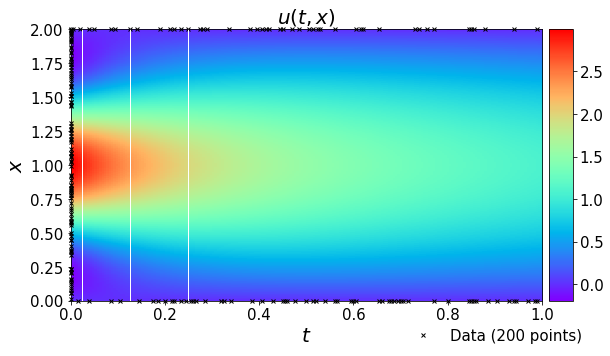

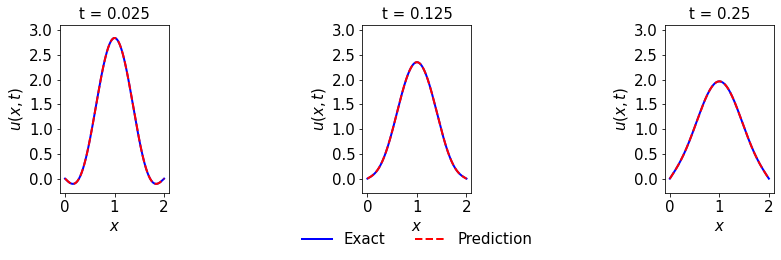

In [102]:
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

#first plot
U_pred = griddata(xt_sol, u_pred_te.flatten(), (X, T), method='cubic')

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t_fine.min(), t_fine.max(), x_fine.min(), x_fine.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    xt_train[:,1], 
    xt_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

line = np.linspace(x_fine.min(), x_fine.max(), 2)[:,None]
ax.plot(t_fine[5]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t_fine[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t_fine[50]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()


#second plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)
ax.remove()

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x_fine,U_sol[5,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x_fine,U_pred[5,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(x,t)$')    
ax.set_title(f't = {t_fine[5].item()}', fontsize = 15) #dynamic change here to do
ax.axis('square')
ax.set_xlim([-0.1,L+0.1]) 
ax.set_ylim([u_sol.min() -0.1,u_sol.max()+0.1]) 

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x_fine,U_sol[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x_fine,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(x,t)$')
ax.axis('square')
ax.set_xlim([-0.1,L+0.1])
ax.set_ylim([u_sol.min() -0.1,u_sol.max()+0.1])
ax.set_title(f't = {t_fine[25].item()}', fontsize = 15) 
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x_fine,U_sol[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x_fine,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(x,t)$')
ax.axis('square')
ax.set_xlim([-0.1,L+0.1])
ax.set_ylim([u_sol.min() -0.1 ,u_sol.max()+0.1])    
ax.set_title(f't = {t_fine[50].item()}', fontsize = 15)  

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()

### Plot of the initial solution ($L=2$)
<br>
<div>
  <img src="img/6.PNG" width="500"/>  
</div>